# Análise de sentimento do Twitter (dataset tweetSentBR) com BERTimbau


# Modelos de Linguagem Neurais Pré-treinados

Modelos Neurais estado-da-arte são baseados na arquitetura Transformer e têm todos seus parâmetros pré-treinados com base em tarefas genéricas. Sendo assim, estes modelo só precisam ser refinados (*fine-tuned*) numa tarefa específica.

Vamos ver algumas aplicações de modelos pré-treinados utilizando a bibliotega [HuggingFace](https://huggingface.co/)


## Classificação de Texto

Vamos refinar a arquitetura BERTimbau, versão em Português do BERT, numa tarefa de classificação onde uma revisão de produto será classificada em **Positiva**, **Neutra** ou **Negativa**.

# Preparando o córpus

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tweets_df = pd.read_csv('https://www.dropbox.com/s/kvf25yvk7wd75a4/tweetSentBR.csv?dl=1') 

In [2]:
tweets_df.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,que coisa linda O programa estava mostrando um...,False
1,865583716088766464,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,por mais com as irmãs galvão adorei elas,False
2,865063232201011200,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,1,test,mr CATRA USERNAME lançando sua nova música PPK...,False
3,864668391008763904,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,0,test,quem viu aquela lutadora modela barbuda tatuad...,False
4,865572794016378880,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,-1,test,tô passada com esse cara quanta merda pode sai...,False


## Eliminando as colunas que não serão utilizada

In [3]:
tweets_df.columns

Index(['id', 'hashtag', 'votes', 'hard', 'sentiment', 'group', 'text',
       'repeat'],
      dtype='object')

In [4]:
tweets_df.drop(columns=['id', 'hashtag', 'votes', 'hard', 'group',
       'repeat'], inplace=True)

In [5]:
tweets_df.head()

,sentiment,text
0,1,que coisa linda O programa estava mostrando um...
1,1,por mais com as irmãs galvão adorei elas
2,1,mr CATRA USERNAME lançando sua nova música PPK...
3,0,quem viu aquela lutadora modela barbuda tatuad...
4,-1,tô passada com esse cara quanta merda pode sai...


In [6]:
 tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15047 entries, 0 to 15046
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15047 non-null  object
 1   text       15047 non-null  object
dtypes: object(2)
memory usage: 235.2+ KB


In [7]:
tweets_df.groupby(['sentiment']).count()

,text
sentiment,
-,47
-1,4426
0,3926
1,6648


In [8]:
# removendo as linhas com a variável sentimento como traço '-'

indexNames = tweets_df[ tweets_df['sentiment'] == '-' ].index #obtendo o valor para ajudar a remover a linha
tweets_df.drop(indexNames , inplace=True) #removendo a linha correspondente ao valor informado

In [9]:
# tranformando valores para adequar a os classificadores
tweets_df['sentiment'] = tweets_df['sentiment'].replace(['-1', '0', '1'], [3, 6, 9])
tweets_df['sentiment'] = tweets_df['sentiment'].replace([3, 6, 9], [0, 1, 2])

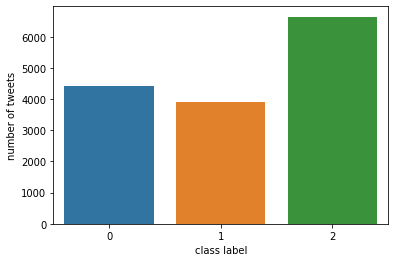

In [10]:
# Visualizando os dados graficamente
sns.countplot(x=tweets_df.sentiment)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

In [11]:
tweets_df.groupby(['sentiment']).count()

,text
sentiment,
0,4426
1,3926
2,6648


## Efetuando a limpeza dos dados

## Removendo apenas os emojis e as palavras USERNAME e NUMBER

In [12]:
# removendo as palavras USERNAME e NUMBER
tweets_df['text_parcial_clean'] = tweets_df['text'].str.replace('USERNAME', '').str.replace('NUMBER', '')

In [13]:
# remover emojis utilizado regex (re)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [14]:
# aplicando a função de limpeza de dados:
tweets_df['text_parcial_clean'] = [remove_emoji(i) for i in tweets_df['text_parcial_clean']]
pd.set_option('display.max_colwidth', None) 

tweets_df.head()

,sentiment,text,text_parcial_clean
0,2,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de NUMBER anos que amor !,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de anos que amor !
1,2,por mais com as irmãs galvão adorei elas,por mais com as irmãs galvão adorei elas
2,2,mr CATRA USERNAME lançando sua nova música PPK CHORA no USERNAME k k k 👅 😉 #MrCatra #PpkChora,mr CATRA lançando sua nova música PPK CHORA no k k k #MrCatra #PpkChora
3,1,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR
4,0,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos 😠,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos


In [15]:
# carregando os textos
text = tweets_df['text']

# carregando as classes
sentiment = tweets_df['sentiment']

# salvando em um dicionário
data = [{ 'X': text, 'y': sentiment} for (text, sentiment) in zip(text, sentiment)] 

Separando os dados em conjunto de treino e teste

In [16]:
size = int(len(data) * 0.2)
treino = data[size:]
teste = data[:size]

len(treino), len(teste)

(12000, 3000)

Importando as dependências. Perceba que o tokenizador e modelo de classificação do BERTimbau são instanciados com os métodos `AutoTokenizer` e `AutoModelForSequenceClassification`. 

Para mais informações, consulte [este link](https://github.com/neuralmind-ai/portuguese-bert).

In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

### Escolhendo o tamanho da sequência

O BERT trabalha com sequências de comprimento fixo. Usaremos uma estratégia simples para escolher o comprimento máximo. Vamos armazenar o tamanho do token de cada avaliação:

In [19]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

token_lens = []

for txt in tweets_df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
max(token_lens)

79

Plotando a distribuição

<Figure size 1000x500 with 0 Axes>

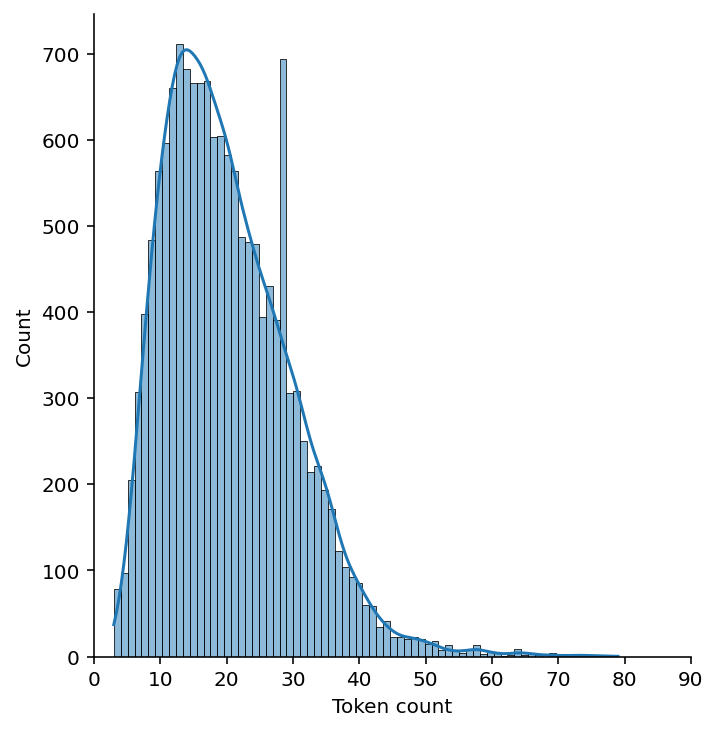

In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.figure(figsize=(10, 5), dpi=100)
sns.displot(data=token_lens, kde=True)
plt.xlim([0, 90])
plt.xlabel('Token count');

O max length ficou igual a 79

Instanciando parâmetros da rede neural

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 3
nepochs = 4
batch_size = 8
batch_status = 32
learning_rate = 2e-5
early_stop = 2

max_length = 128
write_path = 'model'

Separando os dados em batches

In [23]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
testdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

Inicilizando tokenizador, modelo, função de erro e otimizador:

In [24]:
# instanciando o tokenizador e o modelo
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Definindo método de avaliação

In [25]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['X'], inp['y']
    
    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 1)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neutral', 'Positive']))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [26]:
max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  f1, acc = evaluate(model, testdata)
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  if repeat == early_stop:
    break

Progress: 0.08 31
Progress: 0.17 63
Progress: 0.25 95
Progress: 0.34 127
Progress: 0.42 159
Progress: 0.51 191
Progress: 0.59 223
Progress: 0.68 255
Progress: 0.77 287
Progress: 0.85 319
Progress: 0.94 351
              precision    recall  f1-score   support

    Negative       0.35      0.01      0.02       920
     Neutral       0.20      0.95      0.34       620
    Positive       0.36      0.02      0.03      1460

    accuracy                           0.21      3000
   macro avg       0.30      0.33      0.13      3000
weighted avg       0.32      0.21      0.09      3000

Train Epoch: 0 [32/1500 (2%)]	Loss: 0.857097	Total Loss: 1.083690
Train Epoch: 0 [64/1500 (4%)]	Loss: 0.848575	Total Loss: 0.997950
Train Epoch: 0 [96/1500 (6%)]	Loss: 0.723399	Total Loss: 0.953110
Train Epoch: 0 [128/1500 (8%)]	Loss: 0.929648	Total Loss: 0.904960
Train Epoch: 0 [160/1500 (11%)]	Loss: 0.661597	Total Loss: 0.874550
Train Epoch: 0 [192/1500 (13%)]	Loss: 0.739998	Total Loss: 0.852950
Train Epoch: